# Proyecto Simulación Estocástica
## Cableado global con simulated annealing

#### Integrantes:
* Paolo Martiniello
* Álvaro Márquez

### Introducción

El problema de cableado global que se abordará en este proyecto refiere al de unir componentes eléctronicas en un plano o placa a través de cables sin sobrecargar zonas del plano.

La formulación del problema es parecida a la vista en [1] (el paper de Vecchi) pero simplificada, se modela como una grilla de $N_x$ por $N_y$ donde las aristas son caminos donde puede ir los cables y los puntos espacios donde pueden ir las componentes a conectar. Los caminos por los que se conectan son, o bien lineas rectas, o caminos con una única curva los cuales llamaremos "en forma de L". Las componentes a conectar vienen dadas por una lista señalando desde cuál componente se parte y a cuál se quiere llegar.

El objetivo será unir las componentes de la lista de tal forma que los cables se distribuyan de la forma más uniforme posible en los caminos existentes, para ello se introducen los siguientes parámetros: 
* El número de conexiones disponibles, $\pi=(N_x-1)N_y+(N_y-1)N_x$ .
* El largo de Manhattan (mínimo) $W$, corresponde a la suma de largo en $x$ e $y$ del cable.
* El número promedio de cables por enlace, $\rho=W/\pi$.
* El número de conexiones, $M$.
* El largo promedio de cada conexión, $\lambda = W/M$.

Notar que, como se consideran los caminos mínimos entonces para un $M$ dado $W$, $\rho$, y $\lambda$ son constantes.

$M$ se puede descomponer en $M_f$ las conexiones fijas (en linea recta) y $M_r$ las conexiones restantes, las que se unen a través de caminos en L, con lo que el problema se reduce a elegir los caminos para $M_r$ que minimicen sobrecargas de caminos. Para ello se define la función objetivo $$ F=\sum_{v=1} m_v^2 $$ donde $m_v$ es el número de cables en el enlace $v$

Siguiendo la formulación en [1], se define $\epsilon_{iv}\in\{-1,0,+1\}$ para indicar la orientación de la rotación de de la $i$-ésima conexión en el enlace $v$, $a_{iv}=\epsilon_{iv}^2$ la cual indica si en la $i$-ésima conexión existe un giro y $\mu_i\in\{-1,+1\}$ que dice el sentido de la $i$-ésima conexión (vertical u horizontal). Así se tiene que $$ m_v=\sum_i a_{iv}(\epsilon_{iv}\mu_i+1)/2+m_v(0)$$ donde $m_v(0)$ es el aporte de los cables rectos.

Con esto resulta $$ F = \sum_{i,j} J_{ij}\mu_i\mu_j+ \sum_i h_i \mu_i + \text{constantes}$$
Con $h_i=\sum_v \epsilon_{iv}\left(2m_v(0)+\sum_j a_{jv}\right)$ (explicar qué es esto)
y $J_{ij}=\sum_v \epsilon_{iv} \epsilon_{jv}/4$ (explicar tb)

Si bien ambos $h_i$ y $J_{ij}$ dependen de signo, estos se van en promedio, con lo que solo importan las fluctiaciones las que determinan el valor final de $F$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
sns.set_style("darkgrid", {'grid.linestyle': '--'})
import math

In [2]:
#Funcion para crear mapa de aristas y en caso de ser necesario
#toma uno pre existente y los actualiza bajo un cambio de camino
def actualizar_Mapa(x_1, x_2, grid_map, link, L, act=False):
    grid = np.copy(grid_map) #Con esto nos aseguramos de no afectar la grilla entregada
    #Se ecupera la componente correspondiente a las coordenadas entregadas
    comp_x_1 = x_1[0] * L + x_1[1]
    comp_x_2 = x_2[0] * L + x_2[1]
    #Distancia entre componentes
    a = x_2[0] - x_1[0]
    b = x_2[1] - x_1[1]
    if link == 0: #Caso caminos rectos
        if (x_1[0] - x_2[0]) == 0:
            #Actualizamos cantidad de conexiones por arista al sumar un link nuevo
            for i in range(b):
                grid[comp_x_1 + i][comp_x_1 + i + 1] += 1
        else:
            #Actualizamos cantidad de conexiones por arista al sumar un link nuevo
            for i in range(a):
                grid[comp_x_1 + L*i][comp_x_1 + L*(i+1)] += 1 
    elif link == 1: #Caso camino en L con giro a la derecha
        min_y = np.minimum(x_1[1], x_2[1])
        if x_1[1] == min_y: #Componente 1 arriba a la izquierda de la componente 2
            #Actualizamos cantidad de conexiones por arista al sumar un link nuevo
            for i in range(b):
                grid[comp_x_1 + i][comp_x_1 + i + 1] += 1
            for i in range(a):
                grid[comp_x_1 + b + L*i][comp_x_1 + b + L*(i+1)] += 1
            if act: #Verdadero si cambiamos la orientación de un camino en L, por lo cual
            #hay que restar las conexiones que ya no estan
                for i in range(a):
                    grid[comp_x_1 + L*i][comp_x_1 + L*(i+1)] -= 1
                for i in range(b):
                    grid[comp_x_1 + L*a + i][comp_x_1 + L*a + (i+1)] -= 1

        else: #Componente 1 arriba a la derecha de la componente 2
            #Actualizamos cantidad de conexiones por arista al sumar un link nuevo
            for i in range(a):
                grid[comp_x_1 + L*i][comp_x_1 + L*(i+1)] += 1
            for i in range(x_1[1] - x_2[1]):
                grid[comp_x_2 + i][comp_x_2 + i + 1] += 1
            if act: #Verdadero si cambiamos la orientación de un camino en L, por lo cual
            #hay que restar las conexiones que ya no estan
                for i in range(a):
                    grid[comp_x_1 + b + L*i][comp_x_1 + b + L*(i+1)] -= 1
                for i in range(x_1[1] - x_2[1]):
                    grid[comp_x_2 - L*a + i][comp_x_2 - L*a + i + 1] -= 1

    else: #Caso camino en L con giro a la izquierda
        min_y = np.minimum(x_1[1], x_2[1])
        if x_1[1] == min_y: #Componente 1 arriba a la izquierda de la componente 2
            #Actualizamos cantidad de conexiones por arista al sumar un link nuevo
            for i in range(a):
                grid[comp_x_1 + L*i][comp_x_1 + L*(i+1)] += 1
            for i in range(b):
                grid[comp_x_1 + L*a + i][comp_x_1 + L*a + (i+1)] += 1
            if act: #Verdadero si cambiamos la orientación de un camino en L, por lo cual
            #hay que restar las conexiones que ya no estan
                for i in range(b):
                    grid[comp_x_1 + i][comp_x_1 + i + 1] -= 1
                for i in range(a):
                    grid[comp_x_1 + b + L*i][comp_x_1 + b + L*(i+1)] -= 1
        else: #Componente 1 arriba a la derecha de la componente 2
            #Actualizamos cantidad de conexiones por arista al sumar un link nuevo
            for i in range(a):
                grid[comp_x_1 + b + L*i][comp_x_1 + b + L*(i+1)] += 1
            for i in range(x_1[1] - x_2[1]):
                grid[comp_x_2 - L*a + i][comp_x_2 - L*a + i + 1] += 1
            if act: #Verdadero si cambiamos la orientación de un camino en L, por lo cual
            #hay que restar las conexiones que ya no estan
                for i in range(a):
                    grid[comp_x_1 + L*i][comp_x_1 + L*(i+1)] -= 1
                for i in range(x_1[1] - x_2[1]):
                    grid[comp_x_2 + i][comp_x_2 + i + 1] -= 1
    return grid

#Funcion para crear matriz de conexiones, matriz de aristas, coordenadas
#y cantidad de caminos en L
def generarGrilla(L,componentes):
    #Se inicializa las bases para guardar la informacion
    grid_link = [[None for i in range(int(L**2))] for j in range(int(L**2))]
    grid_map = np.zeros((L**2,L**2))
    coord = [None for i in range(int(L**2))]
    num_cam_L = 0
    #Se recorren las componentes para extraer su informacion
    for comp in componentes:
        comp.sort() #Se ordenan las tuplas en [a,b] a < b para disminuir la casuistica
        #Se extraen las coordenadas de las componentes en funcion
        #del tamaño de la grilla
        comp_1 = [int((comp[0]-1)/L), int((comp[0]-1) % L)]
        comp_2 = [int((comp[1]-1)/L), int((comp[1]-1) % L)]
        #Se guardan las coordenadas en un listado
        coord[comp[0]-1] = comp_1
        coord[comp[1]-1] = comp_2
        #Se calculan las distancias en coordenadas de las componentes
        #para decidir bajo que relacion se encuentran(camino recto o en L)
        dif_x = comp_1[0]-comp_2[0]
        dif_y = comp_1[1]-comp_2[1]
        if dif_x == 0 or dif_y==0: #Caso camino recto se asigna un 0 en la grilla de conexion
            grid_link[comp[0]-1][comp[1]-1] = 0
            grid_link[comp[1]-1][comp[0]-1] = 0
            #Se agregan las conexiones utilizadas para conectar componentes
            grid_map = actualizar_Mapa(comp_1, comp_2, grid_map, 0, L)
        else: #Caso camino en L se elige con distribucion uniforme la orientacion
            num_cam_L += 1
            a = np.random.uniform()
            if a <= 0.5:
                eps = 1
            else:
                eps = -1
            #Se agregan las conexiones utilizadas para conectar componentes
            grid_map = actualizar_Mapa(comp_1, comp_2, grid_map, eps, L)
            grid_link[comp[0]-1][comp[1]-1]= eps
            grid_link[comp[1]-1][comp[0]-1] = -(eps)
    return grid_link, grid_map, coord, num_cam_L

#Funcion para encontrar un vecino de una configuración dada
def encontrarVecino(grid_link, grid_map, coords, num_cam_L):
    #A cada camino en L se le asigna la misma probabilidad de ser elegido
    prob = 1/num_cam_L 
    L = int(np.sqrt(len(coords)))
    unif = np.random.uniform() #Variable uniforme a utilizar
    x, y = 0, 0 #Variables para guardar conexión elegida
    prob_acum = 1/num_cam_L #Variable para probabilidad acumulada
    #Se recorre unicamente el triangulo superior de la matriz dado que esta
    #es antisimetrica, por lo que basta recorrer solo un lado
    for i in range(L**2): 
        for j in range(i+1, L**2): 
            #Solo se pueden elegir conexiones entre componentes que existan
            #o que no sean rectas
            if grid_link[i][j] != 0 and grid_link[i][j] != None:
                #Si uniforme esta contenidad en el intervalo [0,prob_acum] se 
                #toman coordenas que esten seleccionadas en el momento
                if prob_acum >= unif: 
                    x = i
                    y = j
                    break
                else: #Si no se sigue buscando
                    prob_acum += prob
        #Una vez ya elegida la conexion a cambiar no es necesario seguir buscando
        if x != 0 or y!= 0: 
            break
    grid_link_2 = np.copy(grid_link)
    #Se inverten valores de la conexion elegida aprovechando que la grilla
    #de conexiones es antisimetrica
    grid_link_2[x][y] = grid_link[y][x]
    grid_link_2[y][x] = grid_link[x][y]
    #Se actualizan conexiones utilizadas entre coordenadas
    grid_map_2 = actualizar_Mapa(coords[x], coords[y], grid_map, grid_link_2[x][y], L, act=True)
    return grid_link_2, grid_map_2

In [3]:
L=3
componentes=[[1,4],[1,7],[1,5],[1,9]]
link, mapa, coord, cam = generarGrilla(L,componentes)
print(coord)
print(mapa)
print(link)

[[0, 0], None, None, [1, 0], [1, 1], None, [2, 0], None, [2, 2]]
[[0. 2. 0. 2. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[None, None, None, 0, 1, None, 0, None, 1], [None, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None], [0, None, None, None, None, None, None, None, None], [-1, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None], [0, None, None, None, None, None, None, None, None], [None, None, None, None, None, None, None, None, None], [-1, None, None, None, None, None, None, None, None]]


In [4]:
#Funcion objetivo a utilizar para 
#simulated annealing
def FunOb(Mat):
    S=0
    for i in range(len(Mat[0,0:])):
        for j in range(i+1,len(Mat[0,0:])):
            S+=(Mat[i,j])**2
    return S

In [5]:
#Funcion de simulated annealing
def SimulacionCableado(beta,MMapa,num_cam_L,conexiones_init,coords_init,pasos):
    #Variables uniformes a utilizar para definir si se realiza
    #la transicion o no
    U = np.random.random(size = pasos)
    #Listas para guardar valores en cada paso para luego
    #poder graficar
    tot_conex = []
    tot_map = []
    F = []
    #Variables en tiempo 0
    conexiones = conexiones_init
    Mapa = MMapa
    #Se haran una cantidad #pasos de transiciones por simulated annealing
    #(no implica necesariamente un cambio cada transicion)
    for i in range(pasos):
        #Se guardan estados actuales en listas a entregar al final
        tot_conex.append(conexiones)
        tot_map.append(Mapa)
        #Se genera un vecino para una posible transicion
        conexiones_prim, Mapa_prim = encontrarVecino(conexiones, Mapa, coords_init, num_cam_L)
        #Calculo de funciones objetivo para estado actual y vecino
        F_prim = FunOb(Mapa_prim)
        F_act = FunOb(Mapa)
        #Calculo del delta a comparar con la variable uniforme
        delta = np.exp(-beta[i]*(F_prim - F_act))
        #Si delta es mayor que la uniforme se genera una transicion
        #hacia el vecino encontrado
        if U[i] <= np.minimum(delta, 1):
            conexiones = conexiones_prim
            Mapa = Mapa_prim
        F.append(FunOb(Mapa)) #Se guarda valor objetivo actual
    return conexiones, Mapa, tot_conex, tot_map, F 

In [26]:
#Funcion para generar dibujo de una configuracion
def generarGraph(Mapa, comps, L, L_2):
    x=[]
    y=[]
    plt.title("Grilla con las componentes")
    plt.xticks(np.linspace(0,L_2,L_2+1))
    plt.yticks(np.linspace(0,L_2,L_2+1))
    plt.xlabel("Cordenada en x")
    plt.ylabel("Cordenada en y")
    plt.xlim(-0.5,L_2-0.5)
    plt.ylim(-0.5,L_2-0.5)
    for C in comps:
        if C!=None:
            x.append(C[0])
            y.append(C[1])

    for k in range(L):
        for j in range(k+1, L):
            comps_1 = [int((k)/L_2), int((k) % L_2)]
            comps_2 = [int((j)/L_2), int((j) % L_2)]
            y_map = [comps_1[0], comps_2[0]]
            x_map = [comps_1[1], comps_2[1]]
            plt.plot(x_map, y_map, linewidth = (Mapa[k,j]), color = "red")
    plt.plot(y,x,"bo",label="Componentes")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


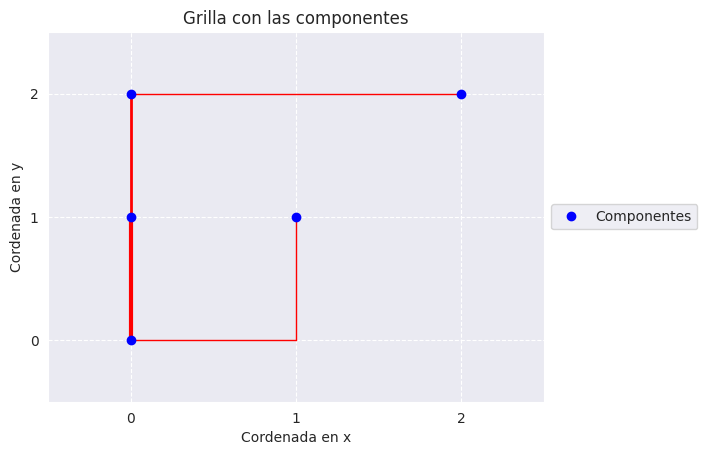

In [37]:
m = np.zeros((9,9))
m[0,1] = 1
m[0,3] = 3
m[1,4] = 1
m[3,6] = 2
m[6,7] = 1
m[7,8] = 1
c = [[None for i in range(9)] for j in range(9)]
c[0][3] = 0
c[0][4] = 1
c[0][6] = 0
c[0][8] = -1
c[3][0] = 0
c[4][0] = 1
c[6][0] = 0
c[8][0] = -1
coords = [[0,0], None, None, [1,0], [1,1], None, [2,0], None, [2,2]]
generarGraph(m, coords, 9,3)

In [7]:
!pip install celluloid==0.2.0

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [8]:
#Funcion para generar animacion de la solucion
import celluloid
from celluloid import Camera
def animar_soluciones(Mapas, comps, L, L_2):
    M = len(Mapas)
    fig, ax = plt.subplots()
    camera = Camera(fig)
    x=[]
    y=[]
    ax.set_title("Grilla con las componentes")
    ax.set_xticks(np.linspace(0,L_2,L_2+1))
    ax.set_yticks(np.linspace(0,L_2,L_2+1))
    ax.set_xlabel("Cordenada en x")
    ax.set_ylabel("Cordenada en y")
    ax.set_xlim(-0.5,L_2-0.5)
    ax.set_ylim(-0.5,L_2-0.5)
    ax.plot(y,x,"bo",label="Componentes")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    for C in comps:
        if C!=None:
            x.append(C[0])
            y.append(C[1])
    #Comenzar a graficar
    for n in range(M):
        Mapa = Mapas[n]
        for k in range(L):
            for j in range(k+1, L):
                comps_1 = [int((k)/L_2), int((k) % L_2)]
                comps_2 = [int((j)/L_2), int((j) % L_2)]
                y_map = [comps_1[0], comps_2[0]]
                x_map = [comps_1[1], comps_2[1]]
                ax.plot(x_map, y_map, linewidth = ((Mapa[k,j]**2)/10), color = "red")

        #Toma foto
        camera.snap()
        if (n+1)%10==0:
            print(n)    
    #Exportar animaciones
    print('exportando')
    anim = camera.animate(blit=False, interval=100)
    anim.save("Cableado_fin"+".gif", writer='Pillow', fps=5) 
    print('termine')

/tmp/ipykernel_120/3716242592.py:5: RuntimeWarning: divide by zero encountered in log
  beta=[np.log(i) for i in range(pasos)]
/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
[[  0. 111.   0. ...   0.   0.   0.]
 [  0.   0. 181. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 222.   0.]
 [  0.   0.   0. ...   0.   0. 119.]
 [  0.   0.   0. ...   0.   0.   0.]]
14316174.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7],

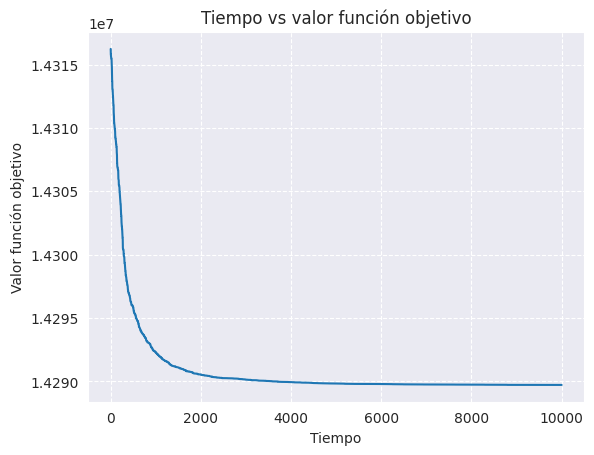

In [9]:
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[np.log(i) for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)


/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
82.28722190856934
[[  0. 110.   0. ...   0.   0.   0.]
 [  0.   0. 200. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 193.   0.]
 [  0.   0.   0. ...   0.   0. 120.]
 [  0.   0.   0. ...   0.   0.   0.]]
14321902.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6,

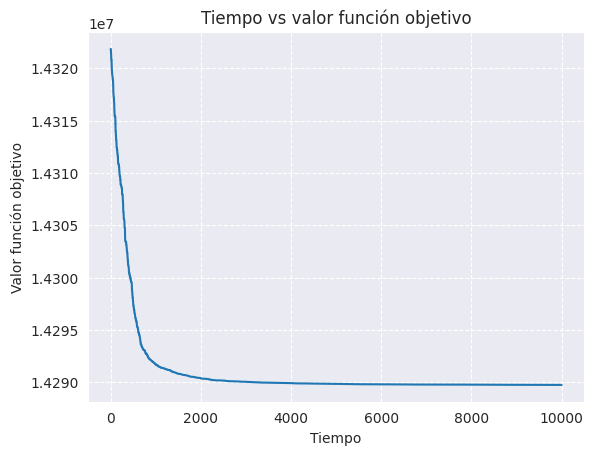

In [30]:
import time

start = time.time()

np.random.seed(5)
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[np.log(i+1) for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

end = time.time()
print(end - start)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)

/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
82.68437933921814
[[  0. 110.   0. ...   0.   0.   0.]
 [  0.   0. 200. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 193.   0.]
 [  0.   0.   0. ...   0.   0. 120.]
 [  0.   0.   0. ...   0.   0.   0.]]
14321902.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6,

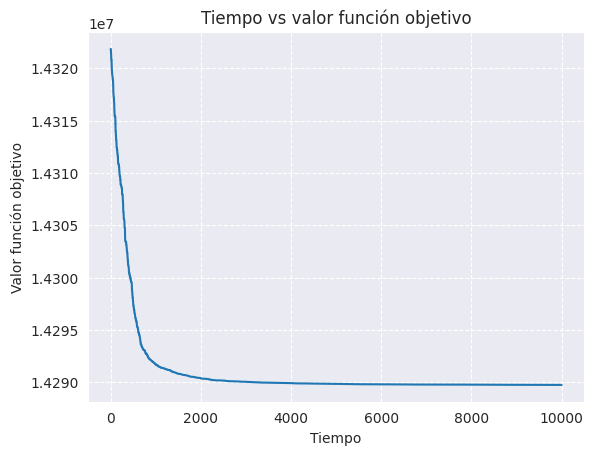

In [31]:
import time

start = time.time()

np.random.seed(5)
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[i*np.log(i+1) for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

end = time.time()
print(end - start)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)

/tmp/ipykernel_120/4231433148.py:10: RuntimeWarning: overflow encountered in exp
  beta=[np.exp(i) for i in range(pasos)]
/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in double_scalars
  delta = np.exp(-beta[i]*(F_prim - F_act))
/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: invalid value encountered in double_scalars
  delta = np.exp(-beta[i]*(F_prim - F_act))
82.40791392326355
[[  0. 110.   0. ...   0.   0.   0.]
 [  0.   0. 200. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 193.   0.]
 [  0.   0.   0. ...   0.   0. 120.]
 [  0.   0.   0. ...   0.   0.   0.]]
14321902.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], 

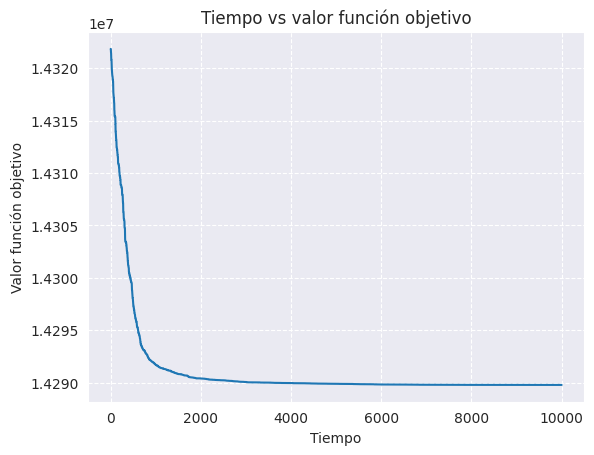

In [32]:
import time

start = time.time()

np.random.seed(5)
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[np.exp(i) for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

end = time.time()
print(end - start)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)

/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
89.11154079437256
[[  0. 110.   0. ...   0.   0.   0.]
 [  0.   0. 200. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 193.   0.]
 [  0.   0.   0. ...   0.   0. 120.]
 [  0.   0.   0. ...   0.   0.   0.]]
14321902.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6,

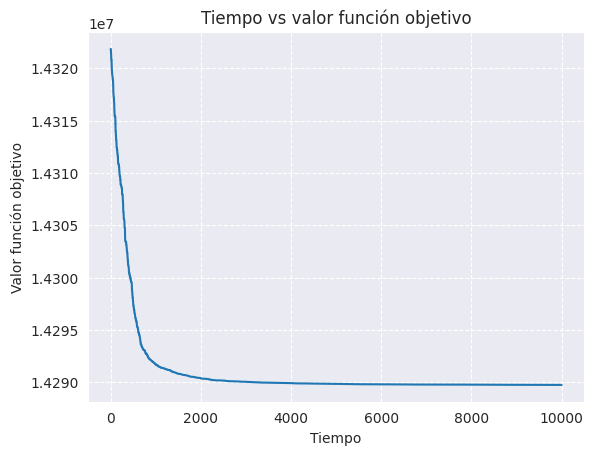

In [33]:
import time

start = time.time()

np.random.seed(5)
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[np.sqrt(i) for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

end = time.time()
print(end - start)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)

/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
85.24781107902527
[[  0. 110.   0. ...   0.   0.   0.]
 [  0.   0. 200. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 193.   0.]
 [  0.   0.   0. ...   0.   0. 120.]
 [  0.   0.   0. ...   0.   0.   0.]]
14321902.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6,

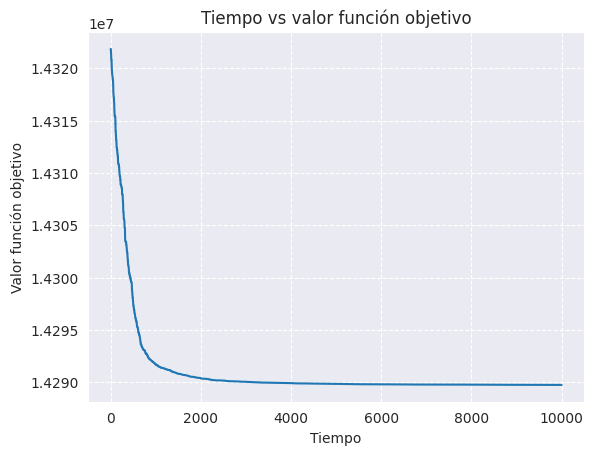

In [34]:
import time

start = time.time()

np.random.seed(5)
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[i**3 for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

end = time.time()
print(end - start)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)

/tmp/ipykernel_120/2653449349.py:26: RuntimeWarning: overflow encountered in exp
  delta = np.exp(-beta[i]*(F_prim - F_act))
84.93386745452881
[[  0. 110.   0. ...   0.   0.   0.]
 [  0.   0. 200. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0. 193.   0.]
 [  0.   0.   0. ...   0.   0. 120.]
 [  0.   0.   0. ...   0.   0.   0.]]
14321902.0
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [4, 10], [5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], [5, 9], [5, 10], [6, 0], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [6, 7], [6, 8], [6, 9], [6,

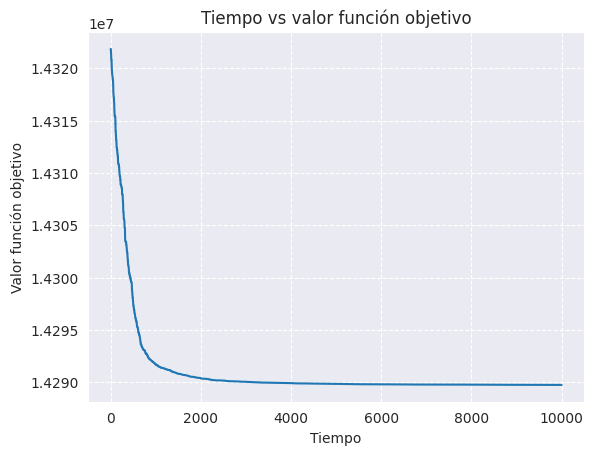

In [35]:
import time

start = time.time()

np.random.seed(5)
pasos = 10000
L_1 = 11

x = [i for i in range(pasos)]
beta=[i**2 for i in range(pasos)]
conex = []
for i in range(1,(L_1**2 + 1)):
    for j in range(i+1,(L_1**2 + 1)):
        conex.append([i,j])

grid_link, grid_map, coord, num = generarGrilla(L_1, conex)
c, m, conexiones, mapa, F = SimulacionCableado(beta, grid_map, num, grid_link, coord, pasos)

end = time.time()
print(end - start)

print(grid_map)
print(FunOb(grid_map))
print(coord)
print(m)
print(FunOb(m))

#generarGraph(grid_map, coord, L_1**2,L_1)
#generarGraph(m, coord, L_1**2,L_1)
plt.plot(x,F)
plt.title("Tiempo vs valor función objetivo")
plt.xlabel("Tiempo")
plt.ylabel("Valor función objetivo")
plt.show()
#animar_soluciones(mapa, coord, L_1**2, L_1)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=55e6a2eb-b9f1-4851-beca-2aade515efc6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>